Data block foundations, in Swifty/functional style

In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_08a_heterogeneous_dictionary")' FastaiNotebook_08a_heterogeneous_dictionary

Installing packages:
	.package(path: "/content/FastaiNotebook_08a_heterogeneous_dictionary")
		FastaiNotebook_08a_heterogeneous_dictionary
With SwiftPM flags: []
Working in: /tmp/tmpsawhcv8k/swift-install
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/3] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


In [0]:
// export
import Path
import TensorFlow

In [0]:
import FastaiNotebook_08a_heterogeneous_dictionary

In [4]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


Load data

In [0]:
let path = downloadImagenette()

In [0]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])
let sd = SplitData(il, fromFunc: {grandParentSplitter(fName: $0, valid: "val")})
var procLabel = CategoryProcessor()
let sld = makeLabeledData(sd, fromFunc: parentLabeler, procLabel: &procLabel)
let rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)
let data = transformData(rawData, tfmItem: { openAndResize(fname: $0, size: 128) })

In [0]:
func modelInit() -> CNNModel { return CNNModel(channelIn: 3, nOut: 10, filters: [64, 64, 128, 256]) }


Stateful optimizer

Before we begin, we create this structure to contain the names of our hyper-parameters. This will give us some tab completion and typo-proof way of handling them.


In [0]:
//export
public struct HyperParams {
    public static let lr = "learningRate"
}



Like in the python version, we create statDelegates that will be responsible for computing/updating statistics in the state (like the moving average of gradients) and stepDelegates that will be responsible for performing a part of the update of the weights.

In PyTorch we created a basic class with functions that needed to be implemented. In swift this is what protocols are for.


In [0]:
//export
public protocol StatDelegate {
    var name: String {get}
    var defaultHPs: [String:Float] {get}
    
    func update(_ state: inout [String:TF], p: TF, 𝛁p: TF, hps: inout [String:Float])
}

public protocol StepDelegate {
    var defaultHPs: [String:Float] {get}
    
    func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float])
}

Those are helper functions to merge dictionaries that we'll use in the StatefulOptimizer.

In [0]:
//export
public func mergeDicts(_ dicts: inout [[String:Float]], with newDict: [String:Float]) {
    for i in dicts.indices { 
        dicts[i].merge(newDict) { (_, new) in new } 
    }
}

public func mergeDicts(_ dicts: inout [[String:Float]], with newDicts: [[String:Float]]) {
    for i in dicts.indices { 
        dicts[i].merge(newDicts[i]) { (_, new) in new } 
    }
}

Those two extensions are there to initialize dicts easily.

In [0]:
//export
extension Dictionary where Value == Int{
    public init(mapFromArrays arrays: [[Key]]){
        self.init(uniqueKeysWithValues: arrays.enumerated().flatMap { i, arr in arr.map { ($0, i) } })
    }
}

extension Dictionary {
    public init(constant: Value, keys: [Key]){
        self.init(uniqueKeysWithValues: keys.map { ($0, constant) })
    }
}

This is the initial state of our StatefulOptimizer. It's a dictionary keyPath (see below) to dictionary that maps names to tensor of floats.

In [0]:
//export
public func initState<Model: Layer>(for model: Model, names: [String]) 
-> [WritableKeyPath<Model.AllDifferentiableVariables, TF>: [String:TF]] {
    return [WritableKeyPath<Model.AllDifferentiableVariables, TF>: [String:TF]](
        constant: [String: TF](constant: TF(0), keys: names),
        keys: model.variables.keyPaths)
}



And we can define the main StatefulOptimizer. It takes a model, hyperparameters for each parameter group, some steppers and stats and a splitArray that defines our different parameter groups.

To understand how this work, you need to know a little bit about keyPaths. This is a tool in swift to access any elements in a nested structure like our models: one model typically has a few attributes that are modules which in turn contain other modules and so forth until we reach the primitives layers like Conv2d or Dense. KeyPaths will allow us to index in that nested structure the objects of a particular type.

For instance, the shortcut keyPaths you can apply to any Layer will find all the tensors of floats. If we apply it to a Model.AllDifferentiableVariables object, we will find all the parameters of the model (since model.allDifferentiableVariables only contain the trainable parameters).

That's why the inner loop of our StatefulOptimizer is over variables.keyPaths. The same keyPath index will give us the gradients. Then we create a state to be a dictionary of such keyPaths to [String:TF] and the splitArray we provide is an array of different keyPaths (each giving us a parameter group) from which we build a splitDict that maps our keyPaths to the index of the corresponding group.


In [0]:
//export
public class StatefulOptimizer<Model: Layer>
    where Model.AllDifferentiableVariables == Model.TangentVector {
    public typealias ModelKeyPath = WritableKeyPath<Model.AllDifferentiableVariables, TF>
    public typealias SplitDict = [ModelKeyPath: Int]
    public var hpGroups: [[String:Float]]
    public var splitDict: SplitDict
    public var states: [ModelKeyPath: [String: TF]]
    public var stats: [StatDelegate]
    public var steppers: [StepDelegate]
    public init(        
        for model: __shared Model,
        steppers: [StepDelegate],
        stats: [StatDelegate],
        hpGroups: [[String:Float]],
        splitArray: [[ModelKeyPath]]
    ) {
        self.hpGroups = Array(repeating: [:], count: hpGroups.count)
        (self.steppers,self.stats) = (steppers,stats)
        self.splitDict = SplitDict(mapFromArrays: splitArray)
        states = [:]
        steppers.forEach { mergeDicts(&self.hpGroups, with: $0.defaultHPs) }
        stats.forEach    { mergeDicts(&self.hpGroups, with: $0.defaultHPs) }
        states = initState(for: model, names: stats.map { $0.name })
        mergeDicts(&self.hpGroups, with: hpGroups)
    }
        
    public func update(
        _ variables: inout Model.AllDifferentiableVariables,
        along direction: Model.TangentVector
    ) {
        for kp in variables.keyPaths {
            var 𝛁p = direction[keyPath: kp]
            var hps = hpGroups[splitDict[kp]!]
            stats.forEach() { $0.update(&states[kp]!, p: variables[keyPath: kp], 𝛁p: 𝛁p, hps: &hps) }
            steppers.forEach() { $0.update(&variables[keyPath: kp], 𝛁p: &𝛁p, state: states[kp]!, hps: &hps) }
            hpGroups[splitDict[kp]!] = hps
        }
    }
}

To make StatefulOptimizer conform to the Optimizer protocol, we need to add a learningRate property.

In [0]:
//export
extension StatefulOptimizer: Optimizer{
    public var learningRate: Float {
        get { return hpGroups.last![HyperParams.lr]! } 
        set { 
            for i in hpGroups.indices {self.hpGroups[i][HyperParams.lr] = newValue }
        }
    }
    //For discriminative learning rates
    public var learningRates: [Float] {
        get { return hpGroups.map { $0[HyperParams.lr]! } }
        set { 
            for i in hpGroups.indices {self.hpGroups[i][HyperParams.lr] = newValue[i] } 
        }
    }
}

When we don't have any parameter groups, we just use one with all the keyPaths. This convenience init automatically does that for us.

In [0]:
//export
extension StatefulOptimizer{
    public convenience init (for model: __shared Model,
                             steppers: [StepDelegate],
                             stats: [StatDelegate],
                             hps: [String:Float]) {
        self.init(for: model,
                  steppers: steppers,
                  stats: stats,
                  hpGroups: [hps],
                  splitArray: [model.variables.keyPaths])
    }
}

We are now ready to define steppers and stats. Let's begin with basic SGD:

In [0]:
//export
public struct SGDStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.lr: 3e-3] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        p -= 𝛁p * hps[HyperParams.lr]!
    }
}


We can check all is working and train:

In [0]:
var hps: [String:Float] = [HyperParams.lr: 0.01]
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(for: model, steppers: [SGDStep()], stats: [], hps: hps)
}

In [0]:
var learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
var recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [19]:
learner.fit(1)

Epoch 0: [1.8049371, 0.37]


Then we can add weight decay and L2 regularization.

In [0]:
//export
public extension HyperParams {
    static let wd = "weightDecay"
}

public struct WeightDecay: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        p *= 1 - hps[HyperParams.lr]! * hps[HyperParams.wd]!
    }
}

In [0]:
//export
public struct L2Regularization: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * p
    }
}

The next step is SGD with momentum. For this we need a statistic that keeps track of the moving average of the gradients.

In [0]:
//export
//Expandable enum to have tab completes/typo-proof for state variable names.
public struct StateKeys {
    public static let avgGrad = "averageGrad"
}

In [0]:
//export
public extension HyperParams {
    static let mom = "momentum"
    static let momDamp = "dampening"
}

public struct AverageGrad: StatDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    public var name: String { return StateKeys.avgGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgGrad]! *= hps[HyperParams.mom]!
        hps[HyperParams.momDamp] = 1.0 - (dampened ? hps[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! += hps[HyperParams.momDamp]! * 𝛁p
    }
}

In [0]:
//export
public struct MomentumStep: StepDelegate {
    public var defaultHPs: [String: Float] = [:]
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String: TF], hps: inout [String:Float]) {
        p -= state[StateKeys.avgGrad]! * hps[HyperParams.lr]!
    }
}

And we can check it trains properly.

In [0]:
let hps: [String:Float] = [HyperParams.lr: 0.01]
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(for: model, steppers: [MomentumStep()], stats: [AverageGrad()], hps: hps)
}

In [0]:
var learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
var recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [27]:
learner.fit(1)

Epoch 0: [1.2563779, 0.594]


The hyper-parameters have taken the default values provided (except for learning rates).

In [28]:
learner.opt.hpGroups[0]

▿ 3 elements
  ▿ 0 : 2 elements
    - key : "momentum"
    - value : 0.9
  ▿ 1 : 2 elements
    - key : "learningRate"
    - value : 0.01
  ▿ 2 : 2 elements
    - key : "dampening"
    - value : 1.0


The next step is Adam. For that we need to keep track of the averages of the gradients squared.

In [0]:
//export
public extension HyperParams {
    static let ²mom = "momentumSquares"
    static let ²momDamp = "dampeningSquares"
}

public extension StateKeys {
    static let avgSqr = "averageSquaredGrad"
}

public struct AverageSquaredGrad: StatDelegate {
    let dampened: Bool
    public init(dampened: Bool = true) { self.dampened = dampened }
    public var name: String { return StateKeys.avgSqr }
    public var defaultHPs: [String: Float] { return [HyperParams.²mom: 0.99] }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgSqr]! *= hps[HyperParams.²mom]!
        hps[HyperParams.²momDamp] = 1.0 - (dampened ? hps[HyperParams.²mom]! : 0.0)
        state[StateKeys.avgSqr]! += hps[HyperParams.²momDamp]! * 𝛁p.squared()
    }
}

And we also need to keep track of the number of iterations we did.

In [0]:
//export
public extension StateKeys {
    static let step = "stepCount"
}

public struct StepCount: StatDelegate {
    public var name: String { return StateKeys.step }
    public var defaultHPs: [String:Float] = [:]
    public init() {}
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.step]! += 1.0
    }
}

In [0]:
//export
//public struct Epsilon: HetDictKey { public static var defaultValue: Float = 1e-5 }
public extension HyperParams {
    static let eps = "epsilon"
}

In [0]:
//export
public struct AdamStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.eps: 1e-5] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String: TF], hps: inout [String:Float]) {
        let step = state[StateKeys.step]!
        let (mom,damp) = (hps[HyperParams.mom]!,hps[HyperParams.momDamp]!)
        let debias1 = damp * (1 - pow(mom, step)) / (1 - mom)
        let num = debias1 * state[StateKeys.avgGrad]!
        
        let (²mom,²damp) = (hps[HyperParams.²mom]!,hps[HyperParams.²momDamp]!)
        let debias2 = ²damp * (1 - pow(²mom, step)) / (1 - ²mom)
        let denom = sqrt(state[StateKeys.avgSqr]!/debias2) + hps[HyperParams.eps]!
        
        p -= hps[HyperParams.lr]! * num / denom
    }
}

Again let's check it's all training properly.

In [0]:
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(
        for: model,
        steppers: [AdamStep()], 
        stats: [AverageGrad(dampened: true), AverageSquaredGrad(), StepCount()], 
        hps: [HyperParams.lr: 1e-3])
}

In [0]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [35]:
learner.fit(1)

Epoch 0: [1.2287602, 0.6]


We can also check the values of the hyper-parameters have been set properly.

In [36]:
learner.opt.hpGroups[0]

▿ 6 elements
  ▿ 0 : 2 elements
    - key : "epsilon"
    - value : 1e-05
  ▿ 1 : 2 elements
    - key : "learningRate"
    - value : 0.001
  ▿ 2 : 2 elements
    - key : "dampening"
    - value : 0.100000024
  ▿ 3 : 2 elements
    - key : "momentumSquares"
    - value : 0.99
  ▿ 4 : 2 elements
    - key : "dampeningSquares"
    - value : 0.00999999
  ▿ 5 : 2 elements
    - key : "momentum"
    - value : 0.9


Defining the Lamb optimizer is as easy as before.

In [0]:
public struct LambStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.eps: 1e-6, HyperParams.wd: 0.0] }
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String: TF], hps: inout [String:Float]) {
        let stepCount = state[StateKeys.step]!
        let (mom,damp) = (hps[HyperParams.mom]!,hps[HyperParams.momDamp]!)
        let debias1 = damp * (1 - pow(mom, stepCount)) / (1 - mom)
        let num = debias1 * state[StateKeys.avgGrad]!
        
        let (²mom,²damp) = (hps[HyperParams.²mom]!,hps[HyperParams.²momDamp]!)
        let debias2 = ²damp * (1 - pow(²mom, stepCount)) / (1 - ²mom)
        let denom = sqrt(state[StateKeys.avgSqr]!/debias2) + hps[HyperParams.eps]!
        
        let step = num / denom + hps[HyperParams.wd]! * p
        let r1 = sqrt((p * p).mean())
        let r2 = sqrt((step * step).mean())
        let factor = min(r1 / r2, Float(10.0))
        p -= hps[HyperParams.lr]! * factor * step
    }
}


Making convenience functions

To easily create our optimizers, we have two convenience functions.


In [0]:
// export
public func sgdOpt<Model>(lr: Float, mom: Float = 0.9, wd: Float = 0.0, dampening: Bool = false
                         ) -> ((Model) -> StatefulOptimizer<Model>) {
    var steppers: [StepDelegate] = (mom != 0) ? [MomentumStep()] : [SGDStep()]
    if wd != 0 { steppers.append(WeightDecay()) }
    let stats = (mom != 0) ? [AverageGrad(dampened: dampening)] : []
    var hps: [String: Float] = [HyperParams.lr: lr]
    if mom != 0 { hps[HyperParams.mom] = mom }
    if wd != 0  { hps[HyperParams.wd ] = wd  }
    return {model in 
        return StatefulOptimizer(for: model, steppers: steppers, stats: stats, hps: hps)}
}

In [0]:
// export
public func adamOpt<Model>(lr: Float, mom: Float = 0.9, beta: Float=0.99, wd: Float = 0.0, eps: Float = 1e-5
                         ) -> ((Model) -> StatefulOptimizer<Model>) {
    var steppers: [StepDelegate] = [AdamStep()]
    if wd != 0 { steppers.append(WeightDecay()) }
    let stats: [StatDelegate] = [AverageGrad(dampened: true), AverageSquaredGrad(), StepCount()]
    var hps: [String: Float] = [HyperParams.lr: lr]
    hps[HyperParams.mom] = mom
    hps[HyperParams.²mom] = beta
    hps[HyperParams.eps] = eps
    if wd != 0  { hps[HyperParams.wd ] = wd  }
    return {model in 
        return StatefulOptimizer(for: model, steppers: steppers, stats: stats, hps: hps)}
}


Schedule the hyperparams

The next thing is that we need to schedule our hyper-parameters. The following function allows us to schedule any of them, as long as they are present in the hpGroups dictionaries.


In [0]:
// export
public extension StatefulOptimizer {
    func setParam(_ hp: String, _ val: Float) {
        for i in 0..<hpGroups.count { hpGroups[i][hp] = val }
    }
}

In [0]:
// export
extension Learner where Opt.Scalar: BinaryFloatingPoint, 
    Opt.Model.AllDifferentiableVariables == Opt.Model.TangentVector{
    public class ParamScheduler: Delegate {
        public override var order: Int { return 1 }
        public typealias ScheduleFunc = (Float) -> Float

        // A learning rate schedule from step to float.
        public var scheduler: ScheduleFunc
        public let hp: String
        
        public init(scheduler: @escaping (Float) -> Float, hp: String) {
            (self.scheduler,self.hp) = (scheduler,hp)
        }
        
        override public func batchWillStart(learner: Learner) {
            let val = scheduler(learner.pctEpochs/Float(learner.epochCount))
            (learner.opt as! StatefulOptimizer<Opt.Model>).setParam(hp, val)
        }
    }
    
    public func makeParamScheduler(_ scheduler: @escaping (Float) -> Float, hp: String) -> ParamScheduler {
        return ParamScheduler(scheduler: scheduler, hp: hp)
    }
}

We can then define a helper function to schedule a 1cycle policy.

In [0]:
// export 
public func oneCycleSchedulers(_ lrMax: Float, pctStart:Float=0.25, divStart: Float = 10, divEnd: Float = 1e5, 
                               moms: (Float,Float,Float) = (0.95,0.85,0.95)) 
-> ((Float) -> Float, (Float) -> Float){
    let lrSched = combineSchedules(
        pcts: [pctStart, 1-pctStart], 
        schedules: [makeAnnealer(start: lrMax/divStart, end: lrMax, schedule: cosineSchedule),
                    makeAnnealer(start: lrMax, end: lrMax/divEnd, schedule: cosineSchedule)])
    let momSched = combineSchedules(
        pcts: [pctStart, 1-pctStart], 
        schedules: [makeAnnealer(start: moms.0, end: moms.1, schedule: cosineSchedule),
                    makeAnnealer(start: moms.1, end: moms.2, schedule: cosineSchedule)])
    return (lrSched, momSched)
}

In [0]:
// export
extension Learner where Opt.Scalar: BinaryFloatingPoint, 
    Opt.Model.AllDifferentiableVariables == Opt.Model.TangentVector{

    public func addOneCycleDelegates(_ lrMax: Float, pctStart:Float=0.25, divStart: Float = 10, divEnd: Float = 1e5, 
                               moms: (Float,Float,Float) = (0.95,0.85,0.95)) {
        let scheds = oneCycleSchedulers(lrMax, pctStart: pctStart, divStart: divStart, divEnd: divEnd, moms: moms)
        addDelegates([makeParamScheduler(scheds.0 , hp: HyperParams.lr), 
                      makeParamScheduler(scheds.1 , hp: HyperParams.mom)])
    }
}

And check it's all training properly.

In [0]:
let optFunc: (CNNModel) -> StatefulOptimizer<CNNModel> = adamOpt(lr: 1e-3, mom: 0.9, beta: 0.99, wd: 1e-2, eps: 1e-6)

In [0]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [46]:
learner.addOneCycleDelegates(1e-3)
learner.fit(1)

Epoch 0: [1.2135706, 0.6]


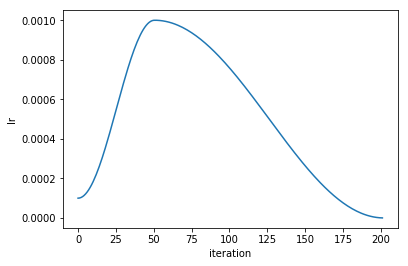

In [47]:
recorder.plotLRs()


Differential learning rates

To train at differential learning rates (or freeze part of the models) we need to pass to our optimizer arrays of KeyPaths (which will define our layer groups). For instance, we can begin with the firt 9 keyPaths (which corresponds to the first three ConvBNs):


In [0]:
func modelInit() -> CNNModel { return CNNModel(channelIn: 3, nOut: 10, filters: [64, 64, 128, 256]) }

In [0]:
var model = modelInit()
let splitArray = [Array(model.variables.keyPaths[0..<9]), Array(model.variables.keyPaths[9...])]

In [0]:
let hpGroups: [[String: Float]] = [[HyperParams.lr: 0], [HyperParams.lr: 0.1]]
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(for: model, steppers: [SGDStep()], stats: [], hpGroups: hpGroups, splitArray: splitArray)
}

In [0]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

First parameter shouldn't change since the corresponding layer group as a LR of 0., second should.

In [52]:
learner.model.convs[0].norm.scale

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [53]:
learner.model.convs[3].norm.scale

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [54]:
learner.fit(1)

Epoch 0: [1.2130678, 0.608]


In [55]:
learner.model.convs[0].norm.scale

[ 0.9911288,  1.0014294, 0.99041396,  1.0011454,   1.034222,  1.0179204, 0.99215996, 0.99435157,
 0.99029994,  0.9929587,  1.0023315, 0.98380834,  1.0093123,  0.9955732, 0.99690735, 0.98794895]


In [56]:
learner.model.convs[3].norm.scale

[ 0.9953649,  0.9973935,  1.0179517,  0.9871102,  1.0011299, 0.99953324,  1.0136515,  0.9875546,
  1.0041703,  0.9971075,  0.9783218,  0.9813575,  1.0210522, 0.99521655,   1.014125,  0.9769132,
  1.0013183,  1.0035138,  0.9946238,  0.9971513, 0.99551237,  0.9871831,  1.0108707,   1.009235,
   0.986868,  0.9992026, 0.99620646, 0.98446673,  0.9792322,  0.9940513, 0.99445766, 0.98304284,
  1.0297406,  0.9902829, 0.98571634,  0.9813884,  1.0047851, 0.98723584,  1.0083523,  1.0129783,
 0.99157697,  1.0010548,  0.9723676,  0.9901454,  0.9921483,  1.0076803,  1.0009801,   1.003216,
  1.0106128, 0.99832064,  0.9773879, 0.96821815, 0.99525034,  0.9843175,  1.0036579,  1.0274135,
  0.9934204,  0.9890184,  0.9882584, 0.99229306, 0.98524535,  1.0221007,  1.0220431,   1.004002]


Another way to get those keyPaths is to use the keyPaths to certain layers then append the keyPaths of all the parameters inside. This function takes a model, a layer and the keyPath that points from model.variables to layer.variables and returns the keyPaths of all the parameters of that layer.

In [0]:
public func parameterKeyPaths<M1, M2>(
    _ model: M1,
    _ kp: WritableKeyPath<M1.AllDifferentiableVariables, M2.AllDifferentiableVariables>,
    _ layer: M2) -> [WritableKeyPath<M1.AllDifferentiableVariables, TF>]
where M1: Layer, M2: Layer {
    return model.variables[keyPath: kp].keyPaths.map { kp.appending(path: $0) }
}

To access a keyPath directly, we use \ commands. Here is the keyPath to the array of convs, which lets us easily get the keyPaths for all the body of our CNN:

In [0]:
let kp = \(CNNModel.AllDifferentiableVariables).convs
let conv = model.convs
let bodyKeyPaths = parameterKeyPaths(model, kp, conv)

Then we could split body and head:

In [59]:
let splitArray = [bodyKeyPaths, model.variables.keyPaths.filter { return !bodyKeyPaths.contains($0) }]
splitArray.map { $0.count }

▿ 2 elements
  - 0 : 21
  - 1 : 2


If we want to refine this a bit and split our body between the first 4 convs and the last 3 we can proceed like this:

In [60]:
let x = [1,2,3]
let y = [4,5,6]
zip(x,y).map { print($0, $1) }

1 4
2 5
3 6


▿ 3 elements
  - 0 : 0 elements
  - 1 : 0 elements
  - 2 : 0 elements


In [0]:
let deepBody = (0..<4).map { parameterKeyPaths(
    model, 
    \(CNNModel.AllDifferentiableVariables).convs.base[$0], 
    model.convs[$0]
) }.reduce([], +)

let upperBody = (4..<7).map { parameterKeyPaths(
    model, 
    \(CNNModel.AllDifferentiableVariables).convs.base[$0], 
    model.convs[$0]
) }.reduce([], +)

In [62]:
let splitArray = [deepBody, upperBody, model.variables.keyPaths.filter { return !bodyKeyPaths.contains($0) }]
splitArray.map { $0.count }

▿ 3 elements
  - 0 : 12
  - 1 : 9
  - 2 : 2


Now let's say we want a parameter group will all the batchnorm layers. KeyPaths allow us to get all the batchnorm layers by saying (to: FABatchNorm<Float>.self). The .keyPaths method we have been using is jsut a shortcut for recursivelyAllWritableKeyPaths(to: TF.self), which grabs all the keypaths to all the tensors.

In [0]:
let bns = model.recursivelyAllWritableKeyPaths(to: FABatchNorm<Float>.self).map { model[keyPath: $0] }

Then we need the keypaths from model.variables to those batchnorms.

In [0]:
let bnKeyPaths = model.variables.recursivelyAllWritableKeyPaths(to: FABatchNorm<Float>.AllDifferentiableVariables.self)

In [65]:
let bnParameters = zip(bnKeyPaths, bns).map { parameterKeyPaths(model, $0, $1) }.reduce([], +)
bnParameters.count

14


Export

In [66]:
import NotebookExport
let exporter = NotebookExport(Path.cwd/"09_optimizer.ipynb")
print(exporter.export(usingPrefix: "FastaiNotebook_"))

success
